In [1]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

In [5]:
# option to display the full text of the string columns
pd.set_option('display.max_colwidth', None)

In [3]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv')

In [6]:
# check for success
df1.head(2)

,Unnamed: 0,Respondent,MainBranch,Hobbyist,ConvertedComp,Country,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,...,PlatformDesireNextYear,PlatformWorkedWith,SOAccount,SOPartFreq,SOVisitFreq,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WorkWeekHrs,DevClass
0,0,1,I am a developer by profession,Yes,NaN,Germany,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;Developer, full-stack",Master’s degree,...,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,No,NaN,Multiple times per day,Computer science,ASP.NET Core,ASP.NET;ASP.NET Core,50.0,other_coder
1,1,2,I am a developer by profession,No,NaN,United Kingdom,NaN,NaN,"Developer, full-stack;Developer, mobile",Bachelor’s degree,...,iOS;Kubernetes;Linux;MacOS,iOS,Yes,Less than once per month or monthly,Multiple times per day,Computer science,NaN,NaN,NaN,other_coder


## Education related information
I will address now the questions I am interested in: 
> Do data developers have more formal educational background than the other developers? In particular, are there more data developers that major in math or stats? How is the education level related to job satisfaction and compensation? 

The questions regarding the education that I am interested in are related to the columns `EdLevel`, '`NewEdImpt`, `UndergradMajor`. I am also interested in how these options are related to salary, i.e. `ConvertedComp` and `JobSat`.

### Prepare and investigate the data

In [7]:
# create the short list of columns for the temporary dataframes
short_list_columns = ['Respondent', 'MainBranch', 'ConvertedComp', 
                     'Country', 'DevType', 'EdLevel', 'JobSat', 'EdImpt',
                      'UndergradMajor', 'WorkWeekHrs', 'DevClass']

In [8]:
# create a temporary dataframe with data coders for the tasks related to the education questions
df1_ed = df1.loc[:, short_list_columns]
df1_ed.head(2)

,Respondent,MainBranch,ConvertedComp,Country,DevType,EdLevel,JobSat,EdImpt,UndergradMajor,WorkWeekHrs,DevClass
0,1,I am a developer by profession,NaN,Germany,"Developer, desktop or enterprise applications;Developer, full-stack",Master’s degree,Slightly satisfied,Fairly important,Computer science,50.0,other_coder
1,2,I am a developer by profession,NaN,United Kingdom,"Developer, full-stack;Developer, mobile",Bachelor’s degree,Very dissatisfied,Fairly important,Computer science,NaN,other_coder


In [9]:
# get the question about education level
dfs[dfs.Column == 'EdLevel']['QuestionText']

14    Which of the following best describes the highest level of formal education that you’ve completed?
Name: QuestionText, dtype: object

In [11]:
# get the curated choices for the education level question
df1.EdLevel.unique()

array(['Master’s degree', 'Bachelor’s degree', nan, 'Secondary school',
       'Professional degree', 'College study without degree',
       'Associate degree', 'Other doctoral degree',
       'Primary/elementary school', 'No formal education'], dtype=object)

In [12]:
# get the question about undergraduate degree
dfs[dfs.Column == 'UndergradMajor']['QuestionText']

54    What was your primary field of study?
Name: QuestionText, dtype: object

In [13]:
# get the curated choices for the field of study
df1.UndergradMajor.unique()

array(['Computer science', nan, 'Mathematics or statistics',
       'Engineering other', 'Humanities', 'Health science',
       'Information system', 'Web dev/design', 'Natural science', 'Arts',
       'No major', 'Social science', 'Business'], dtype=object)

In [14]:
# get the question about the importance of formal education
dfs[dfs.Column == 'NEWEdImpt']['QuestionText']

29    How important is a formal education, such as a university degree in computer science, to your career?
Name: QuestionText, dtype: object

In [15]:
# get the choices for the education importance question
df1.EdImpt.unique()

array(['Fairly important', nan, 'Not at all important/not necessary',
       'Very important', 'Somewhat important', 'Critically important'],
      dtype=object)

## Formal education and the two classes of developers

### The education levels of data coders compared with the other coders

In [36]:
# use groupby() to get the percentage of developers in each education level
EdLevel_perc = df1.groupby('DevClass')['EdLevel'].value_counts(normalize=True)
EdLevel_perc.round(4)*100

DevClass     EdLevel                     
data_coder   Bachelor’s degree               41.77
             Master’s degree                 32.72
             College study without degree     9.28
             Other doctoral degree            7.59
             Secondary school                 3.34
             Associate degree                 2.25
             Professional degree              1.51
             No formal education              0.79
             Primary/elementary school        0.75
other_coder  Bachelor’s degree               47.00
             Master’s degree                 21.09
             College study without degree    13.19
             Secondary school                 9.18
             Associate degree                 3.38
             Other doctoral degree            2.13
             Primary/elementary school        1.80
             Professional degree              1.37
             No formal education              0.87
Name: EdLevel, dtype: float64

In [39]:
# convert the series into a dataframe object
EdLevel_perc = EdLevel_perc.reset_index(name='perc')
EdLevel_perc

,DevClass,EdLevel,perc
0,data_coder,Bachelor’s degree,0.417667
1,data_coder,Master’s degree,0.327235
2,data_coder,College study without degree,0.092763
3,data_coder,Other doctoral degree,0.075865
4,data_coder,Secondary school,0.033446
5,data_coder,Associate degree,0.022492
6,data_coder,Professional degree,0.015150
7,data_coder,No formal education,0.007924
8,data_coder,Primary/elementary school,0.007458
9,other_coder,Bachelor’s degree,0.469969


In [40]:
# rearrange the data to have two coder types as columns
EdLevel_perc = EdLevel_perc.pivot(index='EdLevel',columns='DevClass',values='perc')
EdLevel_perc

DevClass,data_coder,other_coder
EdLevel,,
Associate degree,0.022492,0.033777
Bachelor’s degree,0.417667,0.469969
College study without degree,0.092763,0.131894
Master’s degree,0.327235,0.210931
No formal education,0.007924,0.008700
Other doctoral degree,0.075865,0.021269
Primary/elementary school,0.007458,0.017953
Professional degree,0.015150,0.013715
Secondary school,0.033446,0.091791


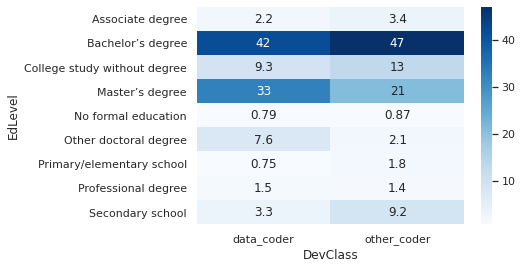

In [41]:
# plot the heatmap
sns.heatmap(EdLevel_perc.round(4)*100, cmap='Blues', annot = True);

#### Comments on education levels:
We observe from this heat map, that the percentages of data coders with higher education degrees (Master, Doctoral or Professional) are higher than the corresponding percentages for the other developers, in particular Master and Other Doctoral degrees. Almost half of the other coders have a Bachelor's degree, the corresponding percentage is lower among the data coders. 